# Forecasting with an RNN

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  
  
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

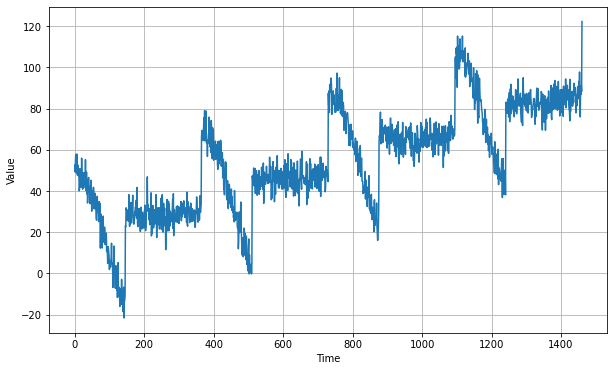

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Simple RNN Forecasting

In [5]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)  # 128 x 30 x 100  because 100 units in layer

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),       # to set the dim to 3D and more https://www.tensorflow.org/api_docs/python/tf/expand_dims
                      input_shape=[None]),                        # any dims is allowed
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),                                    # this is sequence to vector RNN
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)                        # what is the purpose ? normalize here it is scaling to stabalize. High value so small weights can be used.
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])  # note validation data is not used here b/c of learning rate finder

Epoch 1/100
8/8 [==============================] - 4s 541ms/step - loss: 49.5421 - mae: 50.8963
Epoch 2/100
8/8 [==============================] - 1s 76ms/step - loss: 22.4395 - mae: 23.2030
Epoch 3/100
8/8 [==============================] - 1s 77ms/step - loss: 18.4147 - mae: 19.5124
Epoch 4/100
8/8 [==============================] - 1s 79ms/step - loss: 16.8015 - mae: 17.3120
Epoch 5/100
8/8 [==============================] - 1s 81ms/step - loss: 15.7447 - mae: 16.1971
Epoch 6/100
8/8 [==============================] - 1s 78ms/step - loss: 14.9736 - mae: 15.5585
Epoch 7/100
8/8 [==============================] - 1s 82ms/step - loss: 14.3579 - mae: 14.9520
Epoch 8/100
8/8 [==============================] - 1s 80ms/step - loss: 14.3614 - mae: 14.6318
Epoch 9/100
8/8 [==============================] - 1s 75ms/step - loss: 14.2957 - mae: 14.4190
Epoch 10/100
8/8 [==============================] - 1s 83ms/step - loss: 13.7645 - mae: 14.0410
Epoch 11/100
8/8 [==============================

8/8 [==============================] - 0s 62ms/step - loss: 2740.8581 - mae: 2699.9087
Epoch 86/100
8/8 [==============================] - 0s 62ms/step - loss: 4608.2546 - mae: 4763.1675
Epoch 87/100
8/8 [==============================] - 1s 74ms/step - loss: 6993.7507 - mae: 7329.3325
Epoch 88/100
8/8 [==============================] - 1s 79ms/step - loss: 9121.1370 - mae: 8869.6328
Epoch 89/100
8/8 [==============================] - 1s 63ms/step - loss: 10122.5169 - mae: 9893.8096
Epoch 90/100
8/8 [==============================] - 1s 63ms/step - loss: 5025.4150 - mae: 4836.5728
Epoch 91/100
8/8 [==============================] - 0s 61ms/step - loss: 3422.8938 - mae: 3464.6777
Epoch 92/100
8/8 [==============================] - 1s 64ms/step - loss: 3849.5820 - mae: 3734.0747
Epoch 93/100
8/8 [==============================] - 0s 62ms/step - loss: 9609.5440 - mae: 10523.4424
Epoch 94/100
8/8 [==============================] - 1s 64ms/step - loss: 14162.8917 - mae: 14902.4580
Epoch 95/

(1e-07, 0.0001, 0.0, 30.0)

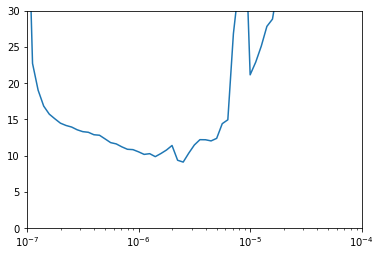

In [6]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=50)           # wait till no change in the mae for 50 epochs
model_checkpoint = keras.callbacks.ModelCheckpoint(                   # save model everytime it improves against validation data set
    "my_checkpoint", save_best_only=True)
model.fit(train_set, epochs=500,
          validation_data=valid_set,                                  # notice two call backs here
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
      8/Unknown - 3s 355ms/step - loss: 59.2325 - mae: 60.3560WARNING:tensorflow:From C:\Users\Amir\anaconda3\envs\tf\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1781: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: my_checkpoint\assets
8/8 [==============================] - 10s 1s/step - loss: 59.2325 - mae: 60.3560 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/500
8/8 [==============================] - 7s 820ms/step - loss: 37.5403 - mae: 37.3106 - val_loss: 11.4775 - val_mae: 11.7886
Epoch 3/500
8/8 [==============================] - 1s 85ms/step - loss: 24.1428 - mae: 24.0714 - val_loss: 12.7572 - val_mae: 13.0819
Epoch 4/500
8/8 [==============================] - 1s 83ms/step - loss: 17.0090 - mae: 17.6511 - val_

8/8 [==============================] - 1s 94ms/step - loss: 4.9012 - mae: 5.3443 - val_loss: 5.1158 - val_mae: 5.5626
Epoch 110/500
8/8 [==============================] - 1s 91ms/step - loss: 4.7380 - mae: 5.2962 - val_loss: 5.9152 - val_mae: 6.3078
Epoch 111/500
8/8 [==============================] - 1s 84ms/step - loss: 4.7240 - mae: 5.3039 - val_loss: 4.8984 - val_mae: 5.4111
Epoch 112/500
8/8 [==============================] - 1s 101ms/step - loss: 4.7823 - mae: 5.4268 - val_loss: 5.4896 - val_mae: 5.8614
Epoch 113/500
8/8 [==============================] - 1s 96ms/step - loss: 5.0054 - mae: 5.4835 - val_loss: 5.3334 - val_mae: 5.6938
Epoch 114/500
8/8 [==============================] - 1s 103ms/step - loss: 4.6959 - mae: 5.1513 - val_loss: 4.9177 - val_mae: 5.4885
Epoch 115/500
8/8 [==============================] - 1s 106ms/step - loss: 4.8373 - mae: 5.4322 - val_loss: 5.4332 - val_mae: 5.9719
Epoch 116/500
8/8 [==============================] - 1s 112ms/step - loss: 5.2526 - mae

In [8]:
model = keras.models.load_model("my_checkpoint")   # load the best model saved during training + validation data.

In [9]:
rnn_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

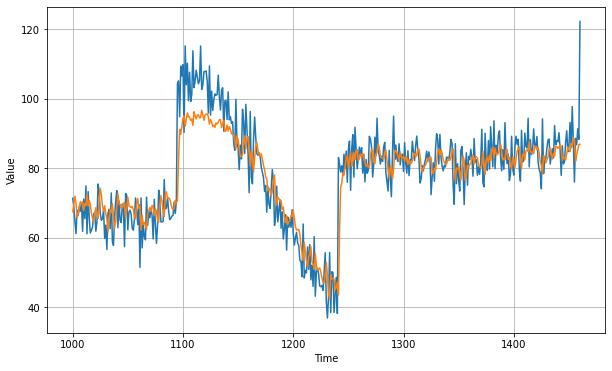

In [10]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)


# Idea is to normalize, remove trend and noise for the analysis.

In [11]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.414164

## Sequence-to-Sequence Forecasting

In [12]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))             # all values except very first. This is sequence not tensor.
    return ds.batch(batch_size).prefetch(1)

In [18]:
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3,
                                               batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())      # labels y are sequence too with one shift.

X: [[[1]
  [2]
  [3]]]
Y: [[[2]
  [3]
  [4]]]
X: [[[3]
  [4]
  [5]]]
Y: [[[4]
  [5]
  [6]]]
X: [[[5]
  [6]
  [7]]]
Y: [[[6]
  [7]
  [8]]]
X: [[[4]
  [5]
  [6]]]
Y: [[[5]
  [6]
  [7]]]
X: [[[6]
  [7]
  [8]]]
Y: [[[7]
  [8]
  [9]]]
X: [[[2]
  [3]
  [4]]]
Y: [[[3]
  [4]
  [5]]]
X: [[[0]
  [1]
  [2]]]
Y: [[[1]
  [2]
  [3]]]


In [16]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)         # why 128 ?

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,       # no need for lambda layer here because it is done in the sequence
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),       # series to series RNN here  - Sequence here in the Y. not tensor. ?
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 4s 516ms/step - loss: 51.7031 - mae: 53.0830
Epoch 2/100
8/8 [==============================] - 1s 80ms/step - loss: 25.2292 - mae: 25.9613
Epoch 3/100
8/8 [==============================] - 1s 74ms/step - loss: 23.1567 - mae: 23.7152
Epoch 4/100
8/8 [==============================] - 1s 73ms/step - loss: 21.1218 - mae: 21.3966
Epoch 5/100
8/8 [==============================] - 1s 81ms/step - loss: 19.5880 - mae: 19.9318
Epoch 6/100
8/8 [==============================] - 1s 79ms/step - loss: 18.7186 - mae: 19.1986
Epoch 7/100
8/8 [==============================] - 1s 82ms/step - loss: 18.1751 - mae: 18.6635
Epoch 8/100
8/8 [==============================] - 1s 90ms/step - loss: 17.9083 - mae: 18.2660
Epoch 9/100
8/8 [==============================] - 1s 75ms/step - loss: 17.5421 - mae: 17.9216
Epoch 10/100
8/8 [==============================] - 1s 74ms/step - loss: 17.3067 - mae: 17.5786
Epoch 11/100
8/8 [==============================

(1e-07, 0.0001, 0.0, 30.0)

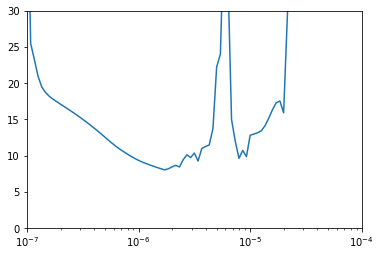

In [19]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [20]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
# note two sequences here .... train_set & valid_set
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)   # you can add model check point here.
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
8/8 [==============================] - 4s 441ms/step - loss: 55.8597 - mae: 56.2826 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/500
8/8 [==============================] - 1s 95ms/step - loss: 33.6745 - mae: 35.1114 - val_loss: 17.4470 - val_mae: 18.0774
Epoch 3/500
8/8 [==============================] - 1s 91ms/step - loss: 29.5657 - mae: 28.6514 - val_loss: 35.8524 - val_mae: 36.0963
Epoch 4/500
8/8 [==============================] - 1s 85ms/step - loss: 21.7688 - mae: 21.6919 - val_loss: 27.8288 - val_mae: 28.4824
Epoch 5/500
8/8 [==============================] - 1s 92ms/step - loss: 18.0302 - mae: 18.5032 - val_loss: 17.8702 - val_mae: 18.4260
Epoch 6/500
8/8 [==============================] - 1s 87ms/step - loss: 15.8201 - mae: 15.8192 - val_loss: 10.6281 - val_mae: 11.1624
Epoch 7/500
8/8 [==============================] - 1s 92ms/step - loss: 13.9125 - mae: 14.3735 - val_loss: 8.7739 - val_mae: 9.2796
Epoch 8/500
8/8 [==============================] - 1s 90m

8/8 [==============================] - 1s 94ms/step - loss: 5.3804 - mae: 5.9188 - val_loss: 5.2403 - val_mae: 5.7024
Epoch 126/500
8/8 [==============================] - 1s 93ms/step - loss: 5.4783 - mae: 5.9083 - val_loss: 5.1686 - val_mae: 5.6640
Epoch 127/500
8/8 [==============================] - 1s 91ms/step - loss: 5.4519 - mae: 5.8979 - val_loss: 5.1556 - val_mae: 5.6217
Epoch 128/500
8/8 [==============================] - 1s 96ms/step - loss: 5.4157 - mae: 5.8928 - val_loss: 5.2615 - val_mae: 5.7583
Epoch 129/500
8/8 [==============================] - 1s 87ms/step - loss: 5.4051 - mae: 5.8810 - val_loss: 5.1096 - val_mae: 5.6117
Epoch 130/500
8/8 [==============================] - 1s 89ms/step - loss: 5.3341 - mae: 5.8681 - val_loss: 5.2225 - val_mae: 5.6829
Epoch 131/500
8/8 [==============================] - 1s 94ms/step - loss: 5.3712 - mae: 5.8576 - val_loss: 5.1866 - val_mae: 5.6872
Epoch 132/500
8/8 [==============================] - 1s 95ms/step - loss: 5.3644 - mae: 5.

In [21]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

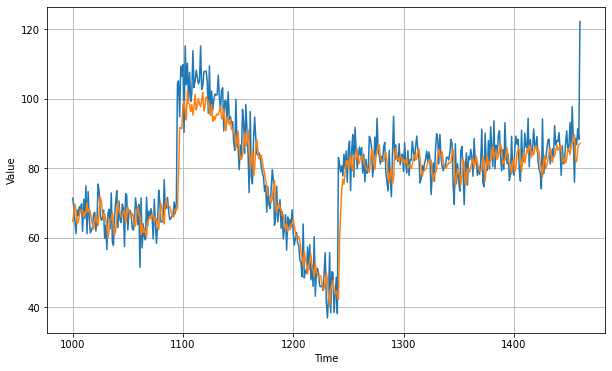

In [22]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [23]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.1336246